In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

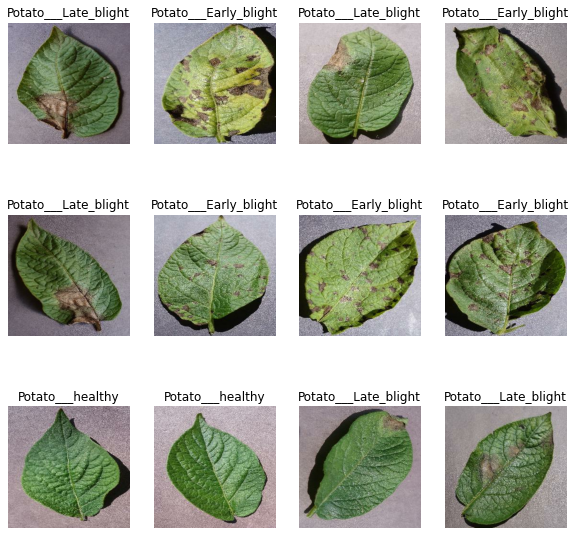

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
len(dataset)

68

In [9]:
def get_dataset_partition_tf(ds, train_split = 0.8, test_split = 0.1, valid_split = 0.1, shuffle = True):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(valid_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),    
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

# Model Architecture - CNN

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
                 
])

model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

# Compiling the Model

In [19]:
model.compile(
optimizer ='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ['accuracy']
)

In [20]:
model_training = model.fit(
train_ds,
batch_size = BATCH_SIZE,
validation_data = val_ds,
verbose = 1,
epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 5s 36ms/step - loss: 0.8956 - accuracy: 0.5399 - val_loss: 0.7911 - val_accuracy: 0.6771
Epoch 2/50
54/54 [==============================] - 1s 22ms/step - loss: 0.6041 - accuracy: 0.7286 - val_loss: 0.5954 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 1s 25ms/step - loss: 0.4187 - accuracy: 0.8287 - val_loss: 0.3367 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 1s 24ms/step - loss: 0.3094 - accuracy: 0.8802 - val_loss: 0.2492 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 1s 22ms/step - loss: 0.2603 - accuracy: 0.8895 - val_loss: 0.2482 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 1s 22ms/step - loss: 0.1915 - accuracy: 0.9184 - val_loss: 0.1958 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 1s 22ms/step - loss: 0.2079 - accuracy: 0.9086 - val_loss: 0.7357 - val_accuracy: 0.7760
Epoch 8/50
54

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 19ms/step - loss: 0.0602 - accuracy: 0.9871


# Accuracy and Raw Curve


In [22]:
model_training.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [23]:
model_training.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:

type(model_training.history['loss'])

list

In [25]:
len(model_training.history['loss'])

50

In [26]:
model_training.history['loss'][:5]

[0.8956111073493958,
 0.6040944457054138,
 0.41874927282333374,
 0.3094015419483185,
 0.2602790594100952]

In [27]:
acc = model_training.history['accuracy']
val_acc = model_training.history['val_accuracy']

loss = model_training.history['loss']
val_loss = model_training.history['val_loss']


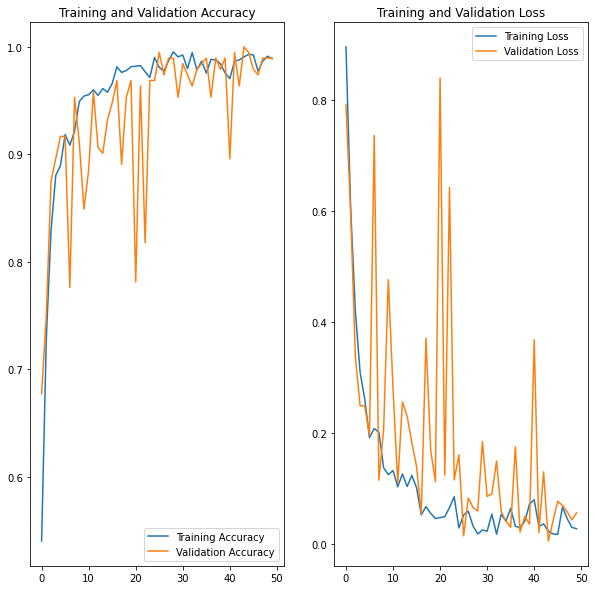

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Run prediction on Sample

first image to predict
Actual label : Potato___Late_blight
Predicted label : Potato___Late_blight


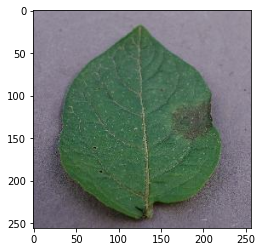

In [56]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print(f'Actual label : {class_names[first_label]}')
    
    batch_prediction = model.predict(images_batch)
    print(f"Predicted label : {class_names[np.argmax(batch_prediction[0])]}")

# Inference on Multiple Images

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

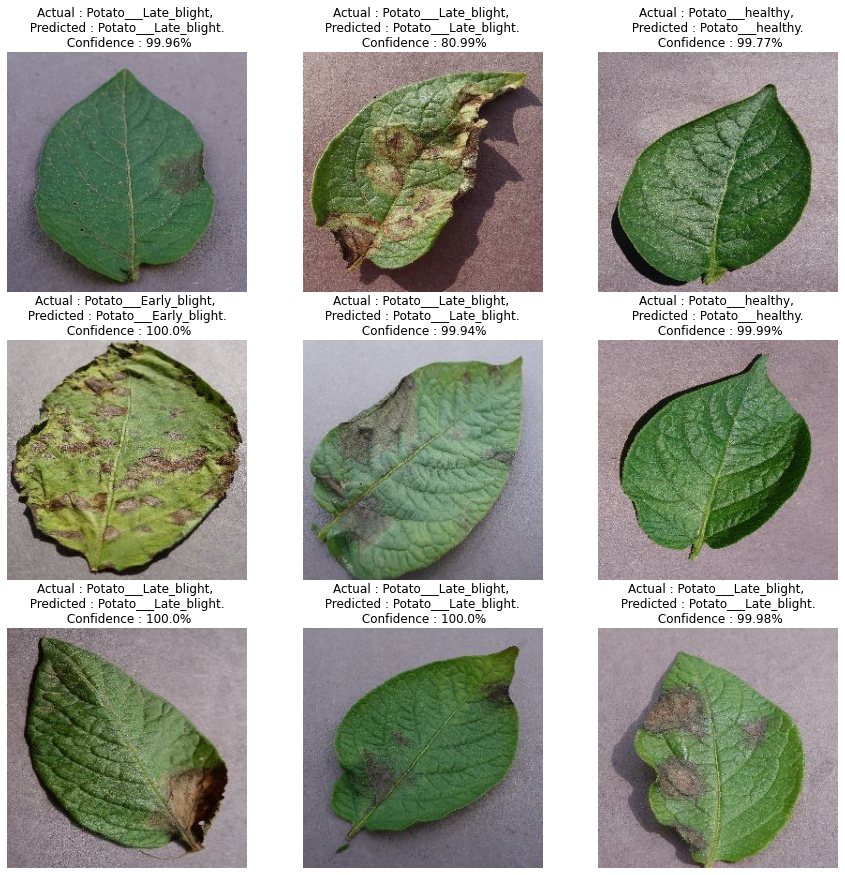

In [70]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}. \n Confidence : {confidence}%")
        
        plt.axis('off')
        

# Saving the Model

In [71]:
import os

In [72]:
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'